In [2]:
import numpy as np
import pandas as pd
import pennylane as qml
from susy_qm import calculate_wz_hamiltonian
from qiskit.quantum_info import SparsePauliOp
import itertools

from qutip import Qobj, concurrence, ptrace

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

from datetime import datetime

In [10]:
a = 1.0
N = 3
potential = 'linear'
boundary_condition = 'periodic'
cutoff = 2
c=0

H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c, to_dense=False)
H

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 352 stored elements and shape (64, 64)>

In [6]:
from scipy.sparse.linalg import eigsh

In [12]:
eigenvalue

array([-0.28077641])

In [11]:
eigenvalue, eigenvector = eigsh(H, k=1, which='SA')
min_eigenvalue = eigenvalue[0]
min_eigenvector = eigenvector[:, 0]


calculating for: 8 3 1.0 linear dirichlet 0
Finding eigenvector
Time taken to find eigenvalues: 0:00:00.065196
Time taken to create psi and rho: 0:00:00.038324
Plotting...
Done


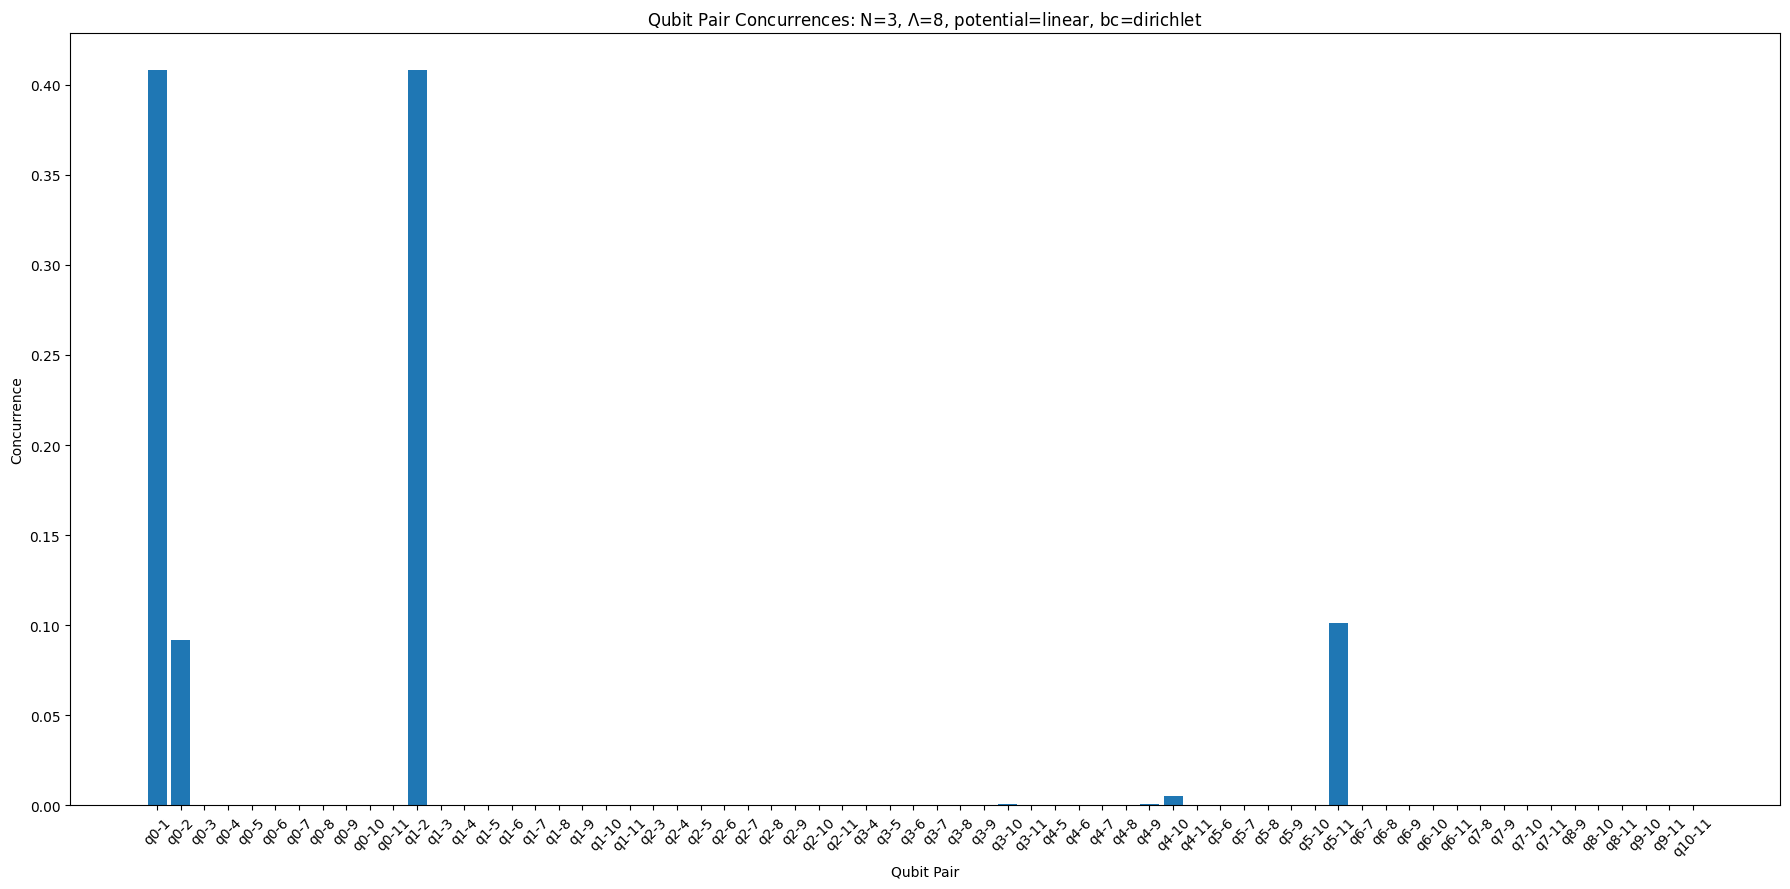

In [16]:
a = 1.0
sites = [3]
potential_list = ['linear']#, 'quadratic']
bc_list = ['dirichlet']#, 'dirichlet']
cutoffs = [8]

qubit_pairs = []
concurrences = []

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:
            for cutoff in cutoffs:

                if potential == 'linear':
                    clist=[0]
                else:
                    clist=[-0.2,-0.8]

                for c in clist:

                    print("calculating for:", cutoff, N, a, potential, boundary_condition, c)
                    H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c, to_dense=False)

                    print("Finding eigenvector")
                    eig_start_time = datetime.now()

                    #eigenvalues, eigenvectors = np.linalg.eig(H)
                    #min_index = np.argmin(eigenvalues)
                    #e_args = np.argsort(eigenvalues)
                    #min_eigenvalue = eigenvalues[min_index]
                    #min_eigenvector = np.asarray(eigenvectors[:,e_args[0]])
                    eigenvalue, eigenvector = eigsh(H, k=1, which='SA')
                    min_eigenvalue = eigenvalue[0]
                    min_eigenvector = eigenvector[:, 0]

                    eig_calc_time = datetime.now() - eig_start_time
                    print(f"Time taken to find eigenvalues: {str(eig_calc_time)}")

                    num_qubits = int(N * (np.log2(max(cutoffs))+1))

                    t1 = datetime.now()
                    psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
                    rho = psi * psi.dag()
                    t2 = datetime.now() - t1
                    print(f"Time taken to create psi and rho: {str(t2)}")

                    for qubit1 in range(0, num_qubits):
                        for qubit2 in range(qubit1 + 1, num_qubits):
                            
                            rho_2q = ptrace(rho, [qubit1, qubit2])
                            conc = concurrence(rho_2q)

                            col_name = f"q{qubit1}-{qubit2}"
                            qubit_pairs.append(col_name)
                            concurrences.append(conc)

                    print("Plotting...")
                    plt.figure(figsize=(18, 9))
                    plt.bar(qubit_pairs, concurrences)
                    plt.xticks(rotation=45)
                    plt.xlabel('Qubit Pair')
                    plt.ylabel('Concurrence')
                    plt.title(f'Qubit Pair Concurrences: N={N}, $\\Lambda$={cutoff}, potential={potential}, bc={boundary_condition}')
                    plt.tight_layout()
                    #plt.show()


                    if potential == 'quadratic':
                        folder = 'C' + str(abs(c)) + '/' + 'N'+ str(N)
                    else:
                        folder = 'N'+ str(N)
                    base_path = os.path.join(r'C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\Wess-Zumino\Entanglement\ConcurrencePlots\BarPlots', boundary_condition, potential, folder)
                    os.makedirs(base_path, exist_ok=True)
                    plt.savefig(base_path + f"\\barplot_{cutoff}.png")
                    print("Done")

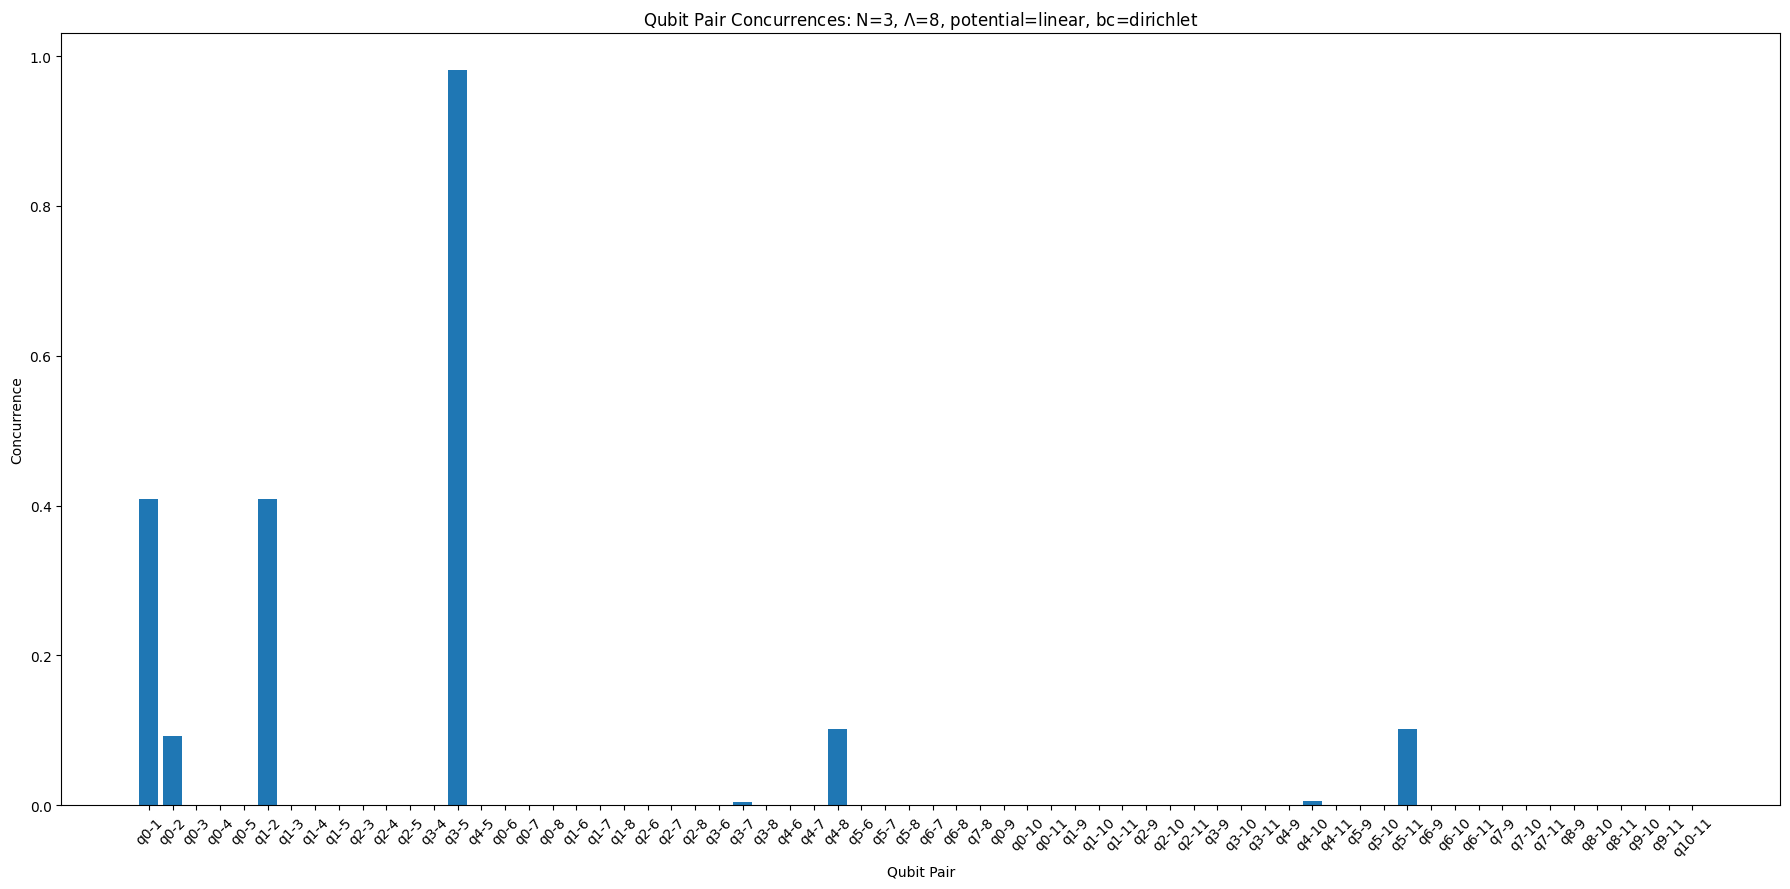

In [60]:
plt.figure(figsize=(18, 9))
plt.bar(qubit_pairs, concurrences)
plt.xticks(rotation=45)
plt.xlabel('Qubit Pair')
plt.ylabel('Concurrence')
plt.title(f'Qubit Pair Concurrences: N={N}, $\\Lambda$={cutoff}, potential={potential}, bc={boundary_condition}')
plt.tight_layout()
#plt.show()


if potential == 'quadratic':
    folder = 'C' + str(abs(c)) + '/' + 'N'+ str(N)
else:
    folder = 'N'+ str(N)
base_path = os.path.join(r'C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\Wess-Zumino\Entanglement\ConcurrencePlots\BarPlots', boundary_condition, potential, folder)
os.makedirs(base_path, exist_ok=True)
plt.savefig(base_path + f"\\barplot_{cutoff}.png")

In [ ]:
a = 1.0
sites = [3]
potential_list = ['linear']#, 'quadratic']
bc_list = ['dirichlet']#, 'dirichlet']
cutoffs = [2,4,8]

for boundary_condition in bc_list:
    for potential in potential_list:
        for N in sites:

            data = {}
            data_qu = (int(np.log2(max(cutoffs))) + 1)*N
            for qubit1 in range(0, data_qu):
                    for qubit2 in range(qubit1 + 1, data_qu):
                            data[f"q{qubit1}-{qubit2}"] = []

            for cutoff in cutoffs:

                if potential == 'linear':
                    c=0
                else:
                    c=-0.2

                print(cutoff, N, a, potential, boundary_condition, c)
                H = calculate_wz_hamiltonian(cutoff, N, a, potential, boundary_condition, c)

                eigenvalues, eigenvectors = np.linalg.eig(H)
                min_index = np.argmin(eigenvalues)
                e_args = np.argsort(eigenvalues)
                min_eigenvalue = eigenvalues[min_index]
                min_eigenvector = np.asarray(eigenvectors[:,e_args[0]])

                hamiltonian = SparsePauliOp.from_operator(H)
                num_qubits = hamiltonian.num_qubits

                psi = Qobj(min_eigenvector, dims=[[2]*num_qubits, [1]*num_qubits])
                rho = psi * psi.dag()

                cutoff_qubits = []
                for qubit1 in range(0, num_qubits):
                    for qubit2 in range(qubit1 + 1, num_qubits):
                        
                        rho_2q = ptrace(rho, [qubit1, qubit2])
                        c = concurrence(rho_2q)

                        col_name = f"q{qubit1}-{qubit2}"
                        data[col_name].append(c)

                        cutoff_qubits.append(col_name)

                nan_qubits = list(set(data.keys()) - set(cutoff_qubits))
                for key in nan_qubits:
                    data[key].append(np.nan)

            data['cutoffs'] = cutoffs.copy()

In [37]:
d = data.copy()
cutoffs = d.pop('cutoffs')
ordered_data = {cutoff: sorted(((k, v[i]) for k, v in d.items()), key=lambda x: (np.isnan(x[1]), -x[1])) for i, cutoff in enumerate(cutoffs)}

df = pd.DataFrame({
    cutoff: [f"{pair[0]} ({pair[1]:.6f})" if not np.isnan(pair[1]) else f"{pair[0]} (nan)" 
             for pair in ordered_data[cutoff]]
    for cutoff in cutoffs
})

df.loc[0:15]

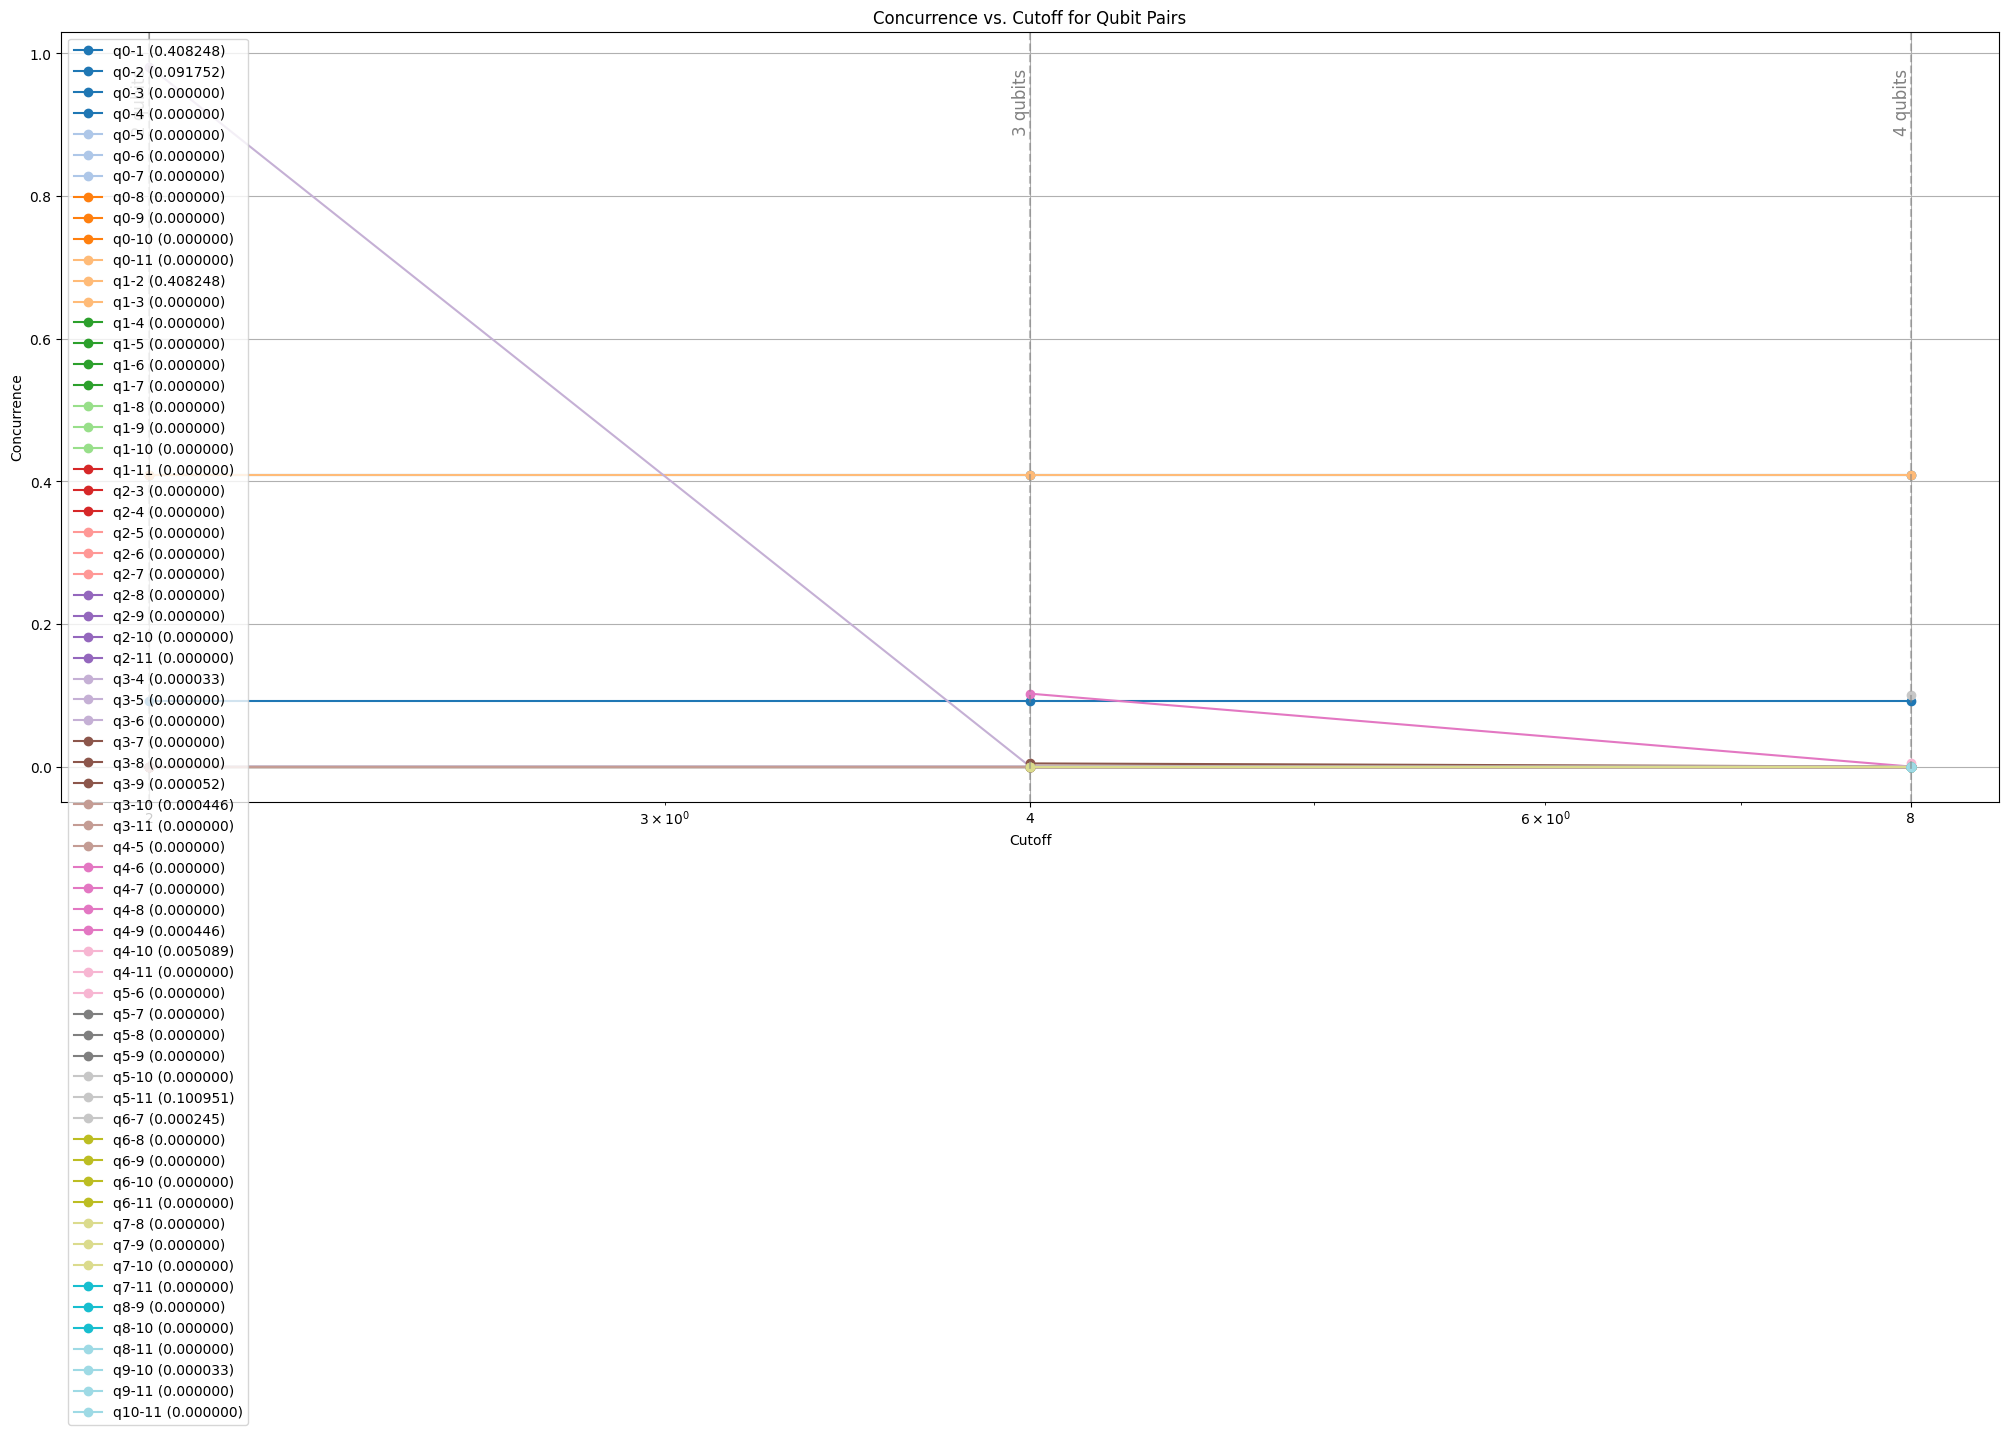

In [42]:
num_pairs = len(data.keys()) - 1
cmap = plt.get_cmap('tab20')
colours = [cmap(i) for i in np.linspace(0, 1, num_pairs)]

plt.figure(figsize=(25,10))
for colour, key in zip(colours, data.keys()):
    if key != "cutoffs":
       
        final_value = data[key][-1]
        label = f"{key} ({final_value:.6f})"
        plt.plot(data["cutoffs"], data[key], marker='o', color=colour, label=label)

for cutoff in data['cutoffs']:
    plt.axvline(x=cutoff, linestyle='--', color='grey', alpha=0.5)
    ymax = plt.ylim()[1]
    
    num_qubits = int(np.log2(cutoff)) + 1
    plt.text(cutoff, ymax * 0.95, f"{num_qubits} qubits",
             rotation=90, verticalalignment='top', horizontalalignment='right',
             color='grey', fontsize=12)

plt.xlabel("Cutoff")
plt.xticks(data["cutoffs"])
plt.xscale("log")


ax = plt.gca()
ax.set_xticks(cutoffs)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.xticks(data["cutoffs"], labels=cutoffs)

plt.ylabel("Concurrence")
plt.title("Concurrence vs. Cutoff for Qubit Pairs")
plt.legend()
plt.grid()
plt.show()
#plt.savefig(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\Entanglement\ConcurrencePlots\plot_{}".format(potential))